In [11]:
import numpy as np
import pandas as pd
import argparse
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import pydotplus
from matplotlib import pyplot as plt
from labels import mac_to_label
import json
import math

In [12]:
inputfile = "data.csv"
outputfile = "tree.json"

# Training set X and Y
Set1 = pd.read_csv(inputfile)
Set = Set1.values.tolist()
X = [i[0:3] for i in Set]
Y =[i[3] for i in Set]

# Test set Xt and Yt
Set2 = pd.read_csv(inputfile)
Sett = Set2.values.tolist()
Xt = [i[0:3] for i in Set]
Yt =[i[3] for i in Set]

# prepare training and testing set
X = np.array(X)
Y = np.array(Y)
Xt = np.array(Xt)
Yt = np.array(Yt)

# decision tree fit
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X, Y)
Predict_Y = dt.predict(X)
print(f"train accuracy: {accuracy_score(Y, Predict_Y)}")

Predict_Yt = dt.predict(Xt)
print(f"test accuracy: {accuracy_score(Yt, Predict_Yt)}")

train accuracy: 0.879490682862549
test accuracy: 0.879490682862549


In [13]:
# output the tree
def get_lineage(tree, feature_names):
    data = {"features": {}, "paths": []}

    thresholds = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    value = tree.tree_.value
 
    # get ids of child nodes
    idx = np.argwhere(left == -1)[:, 0]
    # traverse the tree and get the node information
    def recurse(left, right, child, lineage=None):
        if lineage is None:
            lineage = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'l'
        else:
            parent = np.where(right == child)[0].item()
            split = 'r'
        
        lineage.append((parent, split, thresholds[parent], features[parent]))
        if parent == 0:
            lineage.reverse()
            return lineage
        else:
            return recurse(left, right, parent, lineage)

    for j, child in enumerate(idx):
        clause = []
        for node in recurse(left, right, child):
                if len(str(node)) < 3:
                    continue
                direction = node[1]
                threshold = node[2]
                feature = node[3]
                if direction == "l": # feature <= threshold
                    clause.append({"feature": feature, "operation": "<=", "value": threshold})
                else: # direction == "r" # feature > threshold
                    threshold
                    clause.append({"feature": feature, "operation": ">", "value": threshold})
                    
        a = list(value[node][0])
        ind = a.index(max(a))
        clause = {"conditions": clause, "classification": ind}
        data["paths"].append(clause)

    for i, fe in enumerate(features):
        if tree.tree_.feature[i] != _tree.TREE_UNDEFINED:
            if not fe in data["features"]:
                data["features"][fe] = []
            data["features"][fe].append(thresholds[i])

    return data

In [14]:
# get feature names
feature_names = Set1.columns
file = open(outputfile, "w+")
lineage = get_lineage(dt, feature_names)
file.write(json.dumps(lineage, indent = 4))
file.close()

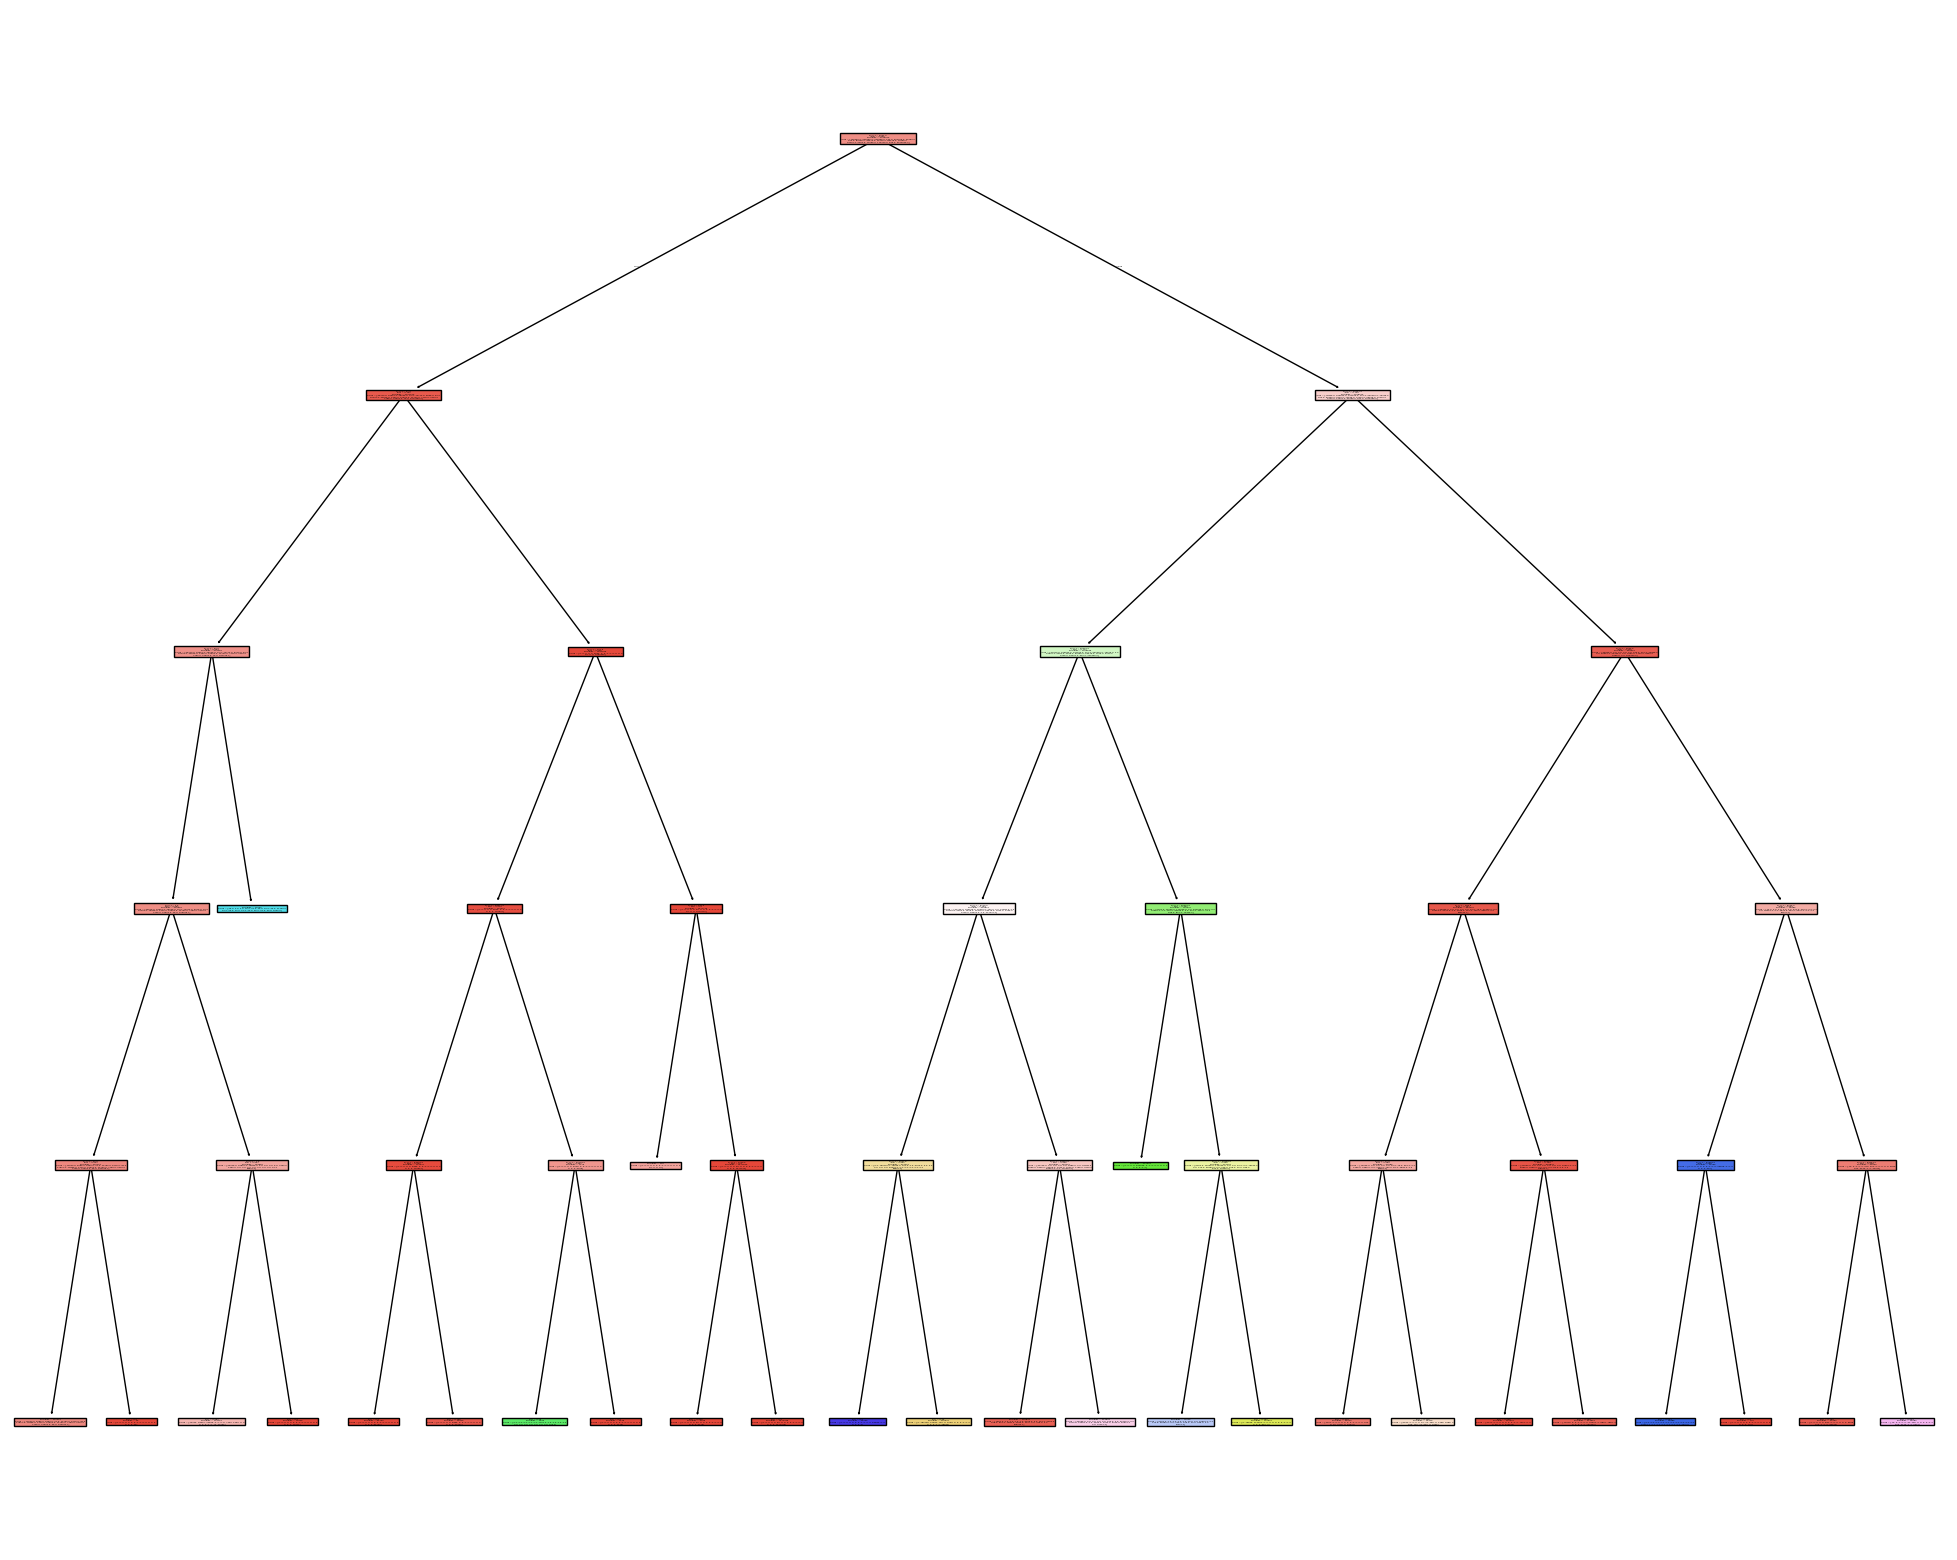

In [15]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt, filled=True)